In [2]:
%load_ext autoreload
%autoreload 2
#Reloads import libraries before every piece of code is run so that changes in function.py reflect immediately


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import time
import random
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

#import functions

from dataset_import import prepareFMNISTData, prepareRailwayData, prepareMedicalData
from distance_metrics import euclideanDistance, manhattenDistance, chebyschevDistance
from PCA import PCA, project
from evaluation_metrics import accuracy, precision, recall, f1Score
from classifiers import knnClassifier, bayesClassifier, bayesClassifierAuto, naiveBayesClassifier
from classifiers import KMeansClassifier, kMeansClassifierAuto
from classifiers import kNearestNeighboursEstimation, parzenWindowEstimation_gaussian, maximumLikelyhoodEstimation
from classifiers import parzenWindowEstimationAuto_gaussian, kNearestNeighboursEstimationAuto


# import sys
# !{sys.executable} -m pip3 install --upgrade pip
# !{sys.executable} -m pip3 install python-mnist


# Medical DataSet Visualization
    - Plot Medical data set, the individual axis 
    - Plot class wise for individual axis, maybe after PCA
    - Make Conclusions

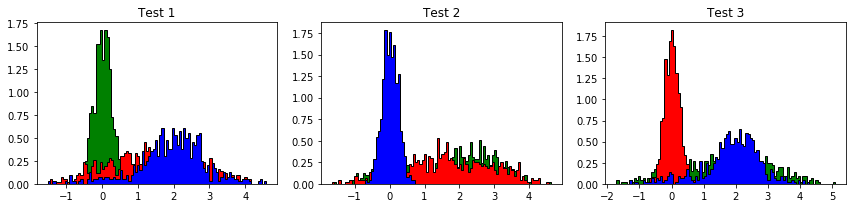

In [59]:

(X_train, y_train, X_val, y_val, X_test, y_test) = prepareMedicalData();
fig=plt.figure(figsize=(12, 3))
columns = 3
rows = 1

for i in range(1, columns*rows +1):
    X_i = [X_train[np.where(y_train==c)][:,i-1] for c in np.unique(y_train)]
    ax = fig.add_subplot(rows, columns, i)
    ax.hist(X_i, color = ['blue', 'red', 'green'], edgecolor = 'black', bins = int(100), histtype = 'stepfilled', density = True)
    ax.set_title("Test " + str(i)) 

fig.tight_layout()
plt.show()



# Comments
- Along each feature, one class stands out while other two collapse, with a different class standing out for each feature.
- Data probably generated custom. Are the three features generated independatly, or part of 3d gaussians?
- Try tests with a 3d gaussian for each dimension. Result? -------- Works
- Try tests along single axis, a naive-bayes approach. Result? ---- Works the same. Data must be independant


In [5]:

y_pred = bayesClassifier(X_test, X_train, y_train, maximumLikelyhoodEstimation)
acc = accuracy(y_pred, y_test)
print("Bayes [multiVariate Gaussian]: " + str(acc))

y_pred = naiveBayesClassifier(X_test, X_train, y_train, maximumLikelyhoodEstimation)
acc = accuracy(y_pred, y_test)
print("Naive Bayes [Gaussian]: " + str(acc))

y_pred = naiveBayesClassifier(X_val, X_train, y_train, parzenWindowEstimation_gaussian, 0.05)
acc = accuracy(y_pred, y_val)
print("Naive Bayes [Parzen Window Estimate]: " + str(acc))

y_pred = naiveBayesClassifier(X_test, X_train, y_train, kNearestNeighboursEstimation, np.sqrt)
acc = accuracy(y_pred, y_test)
print("Naive Bayes [kNN]: " + str(acc))


#maximumLikelyhoodEstimation(X_test, X_train[np.where(y_train==1)])
#maximumLikelyhoodEstimation(X_test, X_train[np.where(y_train==2)])


Bayes [multiVariate Gaussian]: 0.906
Naive Bayes [Gaussian]: 0.918


/Users/eshan/IIT Delhi/ELL409 - Machine Learning/ELL409/Assigment_1/classifiers.py:105: RuntimeWarning: divide by zero encountered in log
  q[:,idx] = priors[idx]*np.sum(np.log([estimator(testX[:,i], np.array([trainX_class_split[:,i]]).transpose(), h, distanceMetric) for i in range(d)]), axis=0)


Naive Bayes [Parzen Window Estimate]: 0.89
Naive Bayes [kNN]: 0.89


# Results
- The class conditional densities can be fit with a single gaussian through MLE
#### Establish that features are independent using some test???
- Since the features are independent, Naive bayes and bayes perform equally well: 90% Accuracy 
- Using parametric estimation techniques (Parzen Window and KNN) works just as fine.

# FMNIST Visualization
    - PCA into lesser dimensions and visualize?
    - Explore Image Reconstruction
   

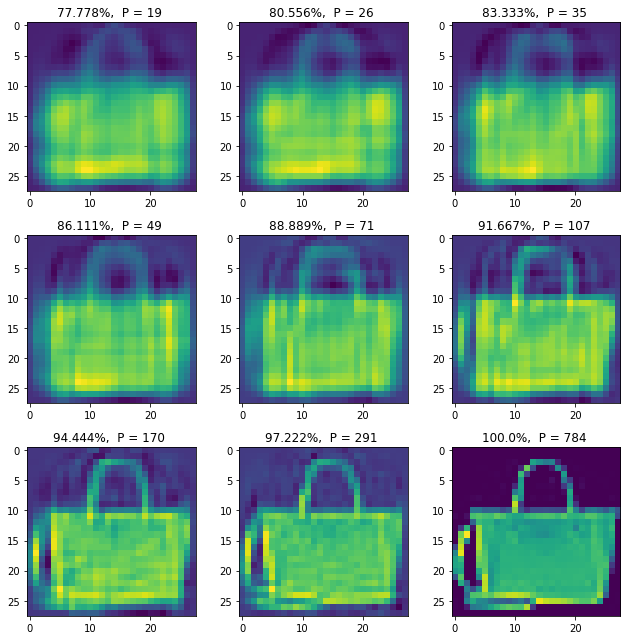

In [6]:
(X_train, y_train, X_val, y_val, X_test, y_test) = prepareFMNISTData();
fig=plt.figure(figsize=(9, 9))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    threshold = 0.75 + i/(columns*rows*4)
    [Z, p, X, U, W] = PCA(X_train, threshold)
    img = X[0].reshape(28, 28)
    ax = fig.add_subplot(rows, columns, i)
    ax.imshow(img)
    ax.set_title(str(round(threshold*100,3))+ '%, '+ ' P = ' + str(p)+ ' ') 

fig.tight_layout()
plt.show()



PCA_Threshold = 1, P = 24


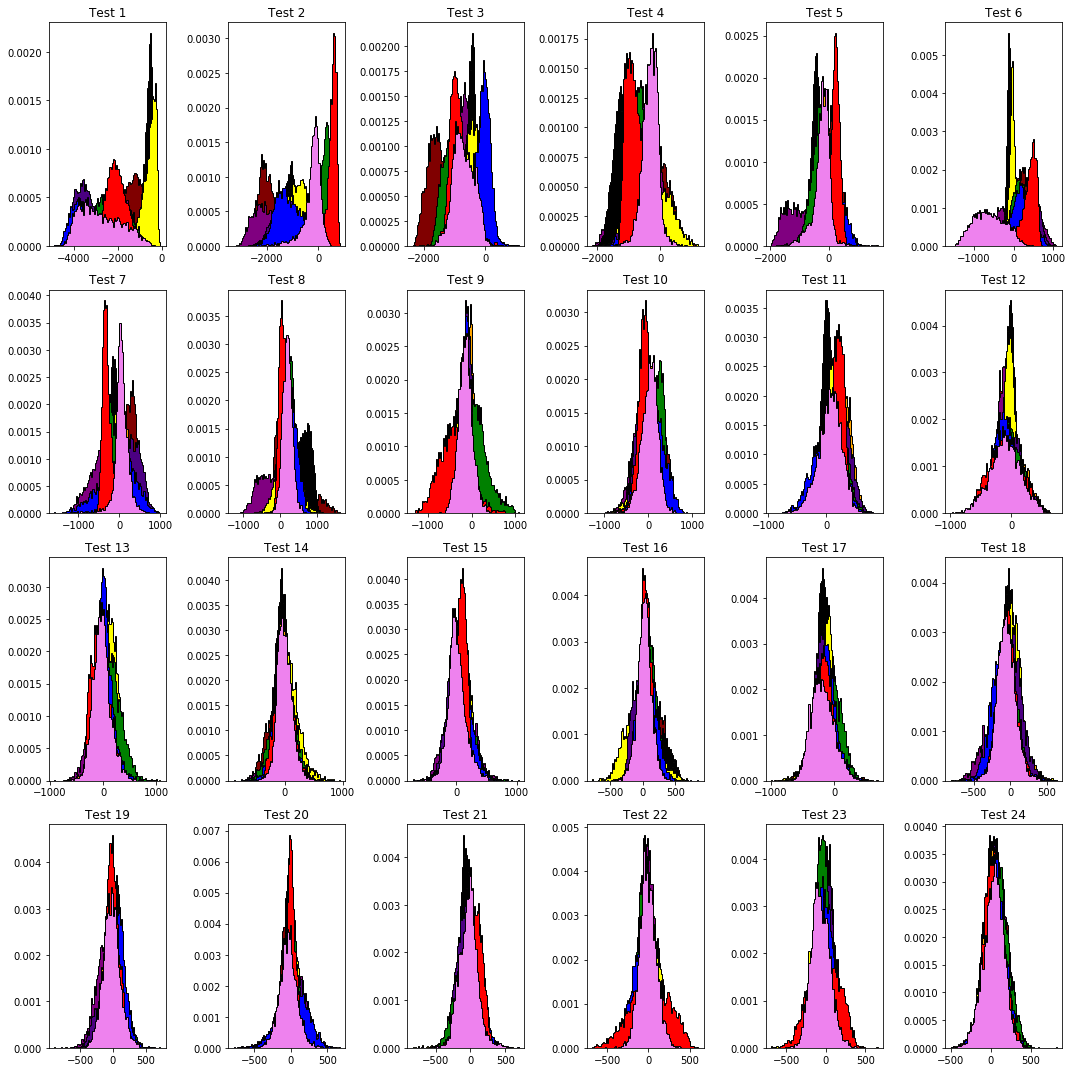

In [315]:
#(X_train, y_train, X_val, y_val, X_test, y_test) = prepareMedicalData();
(X_train, y_train, X_val, y_val, X_test, y_test) = prepareFMNISTData(PCA_threshold=1, PCA_p = 24);
fig=plt.figure(figsize=(15, 15))
columns = 6
rows = 4

colors = ['violet', 'red', 'blue', 'green', 'indigo', 'yellow', 'orange', 'black', 'purple', 'maroon']
for i in range(1, columns*rows +1):
    X_i = [X_train[np.where(y_train==c)][:,i-1] for c in np.unique(y_train)]
    ax = fig.add_subplot(rows, columns, i)
    ax.hist(X_i, color = colors, edgecolor = 'black', bins = int(100), histtype = 'stepfilled', density = True)
    ax.set_title("Test " + str(i)) 

fig.tight_layout()
plt.show()

# Comments
- All the individual are features are gaussians!!
- First twelve features seem much more significant in distinguising between classes than the rest.
- We'll try fitting a multi-variate gaussian and naively fitting gaussians
- Naively fitting gaussians should lead to worse results since features are definitely not decorrelated.


# Test - Fit Gaussians

PCA_Threshold = 1, P = 784


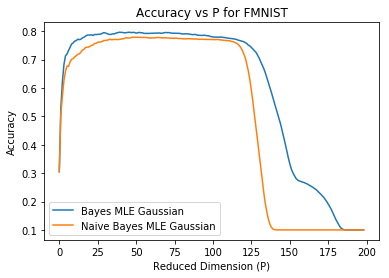

In [463]:
bayes = []
naiveBayes = []
(X_trainC, y_train, X_valC, y_val, X_testC, y_test) = prepareFMNISTData(PCA_threshold=1);
for p in range(1,200):
    X_train = X_trainC[:,:p]
    X_val = X_valC[:,:p]
    y_pred = bayesClassifier(X_val, X_train, y_train, maximumLikelyhoodEstimation)
    bayes.append(accuracy(y_pred, y_val))
    y_pred = naiveBayesClassifier(X_val, X_train, y_train, maximumLikelyhoodEstimation)
    naiveBayes.append(accuracy(y_pred, y_val))

plt.plot(bayes, label = 'Bayes MLE Gaussian')
plt.plot(naiveBayes, label = 'Naive Bayes MLE Gaussian')
plt.xlabel('Reduced Dimension (P)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs P for FMNIST')
plt.axis('on')
plt.legend()


#np.max(Bayes) = 0.796
#np.max(Naive-Bayes) = 0.778

# Observations
- Bayes performs better than Naive Bayes for gaussian class conditional estimations. This is expected because every naive bayes combination can also be represented by a multi-variate gaussian with a diagonal Covariance Matrix.
- The Performance of both measures remains basically constant after P=25, and drops sharply after P = 150. We can conclude that features 25 through 150 are basically not providing enough extra significant information to counter the resulting noise. 
- - Normal assumption might be flawed, in which case, we might want to test non-parametric methods as well. This seems like a good idea because a number of distributions have a visible skew. 


### How to justify the sudden drop of Bayes and Naive-Bayes??
### How does the curse of dimensionality work into the analysis??

# Test - KNN Classifier
- 0.796 is a lower bound for further testing. We can run a KNN classifier for a better bound, since it is proven to have no worse than twice the bayes error
- Choice of Distance metric might play a significant role due to larger number of dimensions

In [370]:
(X_trainC, y_train, X_valC, y_val, X_testC, y_test) = prepareFMNISTData(PCA_threshold = 1);

PCA_Threshold = 1, P = 784


In [ ]:
P = 25
X_train = X_trainC[:,:P]
X_val = X_valC[:,:P]
X_test = X_testC[:,:P]

n_samples = 100
indices = random.sample(range(0, 10000), n_samples)

kList = [1,2,4,8,16,32,64,128,256]
dists = [chebyschevDistance, euclideanDistance, manhattenDistance]

chebyschev__Acc_V_K = []
euclidean__Acc_V_K = []
manhatten__Acc_V_K = []

for K in kList:
    for dist in dists:
        y_pred = knnClassifier(X_val[indices], X_train, y_train, K, dist)
        acc = accuracy(y_pred, y_val[indices])
        if(dist == chebyschevDistance): chebyschev__Acc_V_K.append(acc)
        if(dist == euclideanDistance): euclidean__Acc_V_K.append(acc)
        if(dist == manhattenDistance): manhatten__Acc_V_K.append(acc)
        
    
    

Text(0,0.5,'Accuracy')

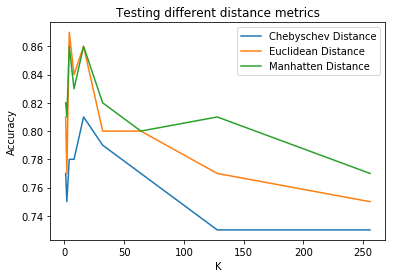

In [407]:
plt.plot(kList, chebyschev__Acc_V_K, label = 'Chebyschev Distance')
plt.plot(kList, euclidean__Acc_V_K, label = 'Euclidean Distance')
plt.plot(kList, manhatten__Acc_V_K, label = 'Manhatten Distance')
plt.legend()
plt.title('Testing different distance metrics')
plt.xlabel('K')
plt.ylabel('Accuracy')

# The above suggests focusing on Euclidean Distance

In [412]:
kList = [1,2,4,8,16,32,64,128,256,512]
pList = [1,2,4,8,16,32,64,128,256]

n_samples = 100
indices = random.sample(range(0, 10000), n_samples)

accuracies = []

for p in pList:
    X_train = X_trainC[:,:p]
    X_val = X_valC[:,:p]
    X_test = X_testC[:,:p]
    
    accK = []
    
    for K in kList:
        y_pred = knnClassifier(X_val[indices], X_train, y_train, K, euclideanDistance)
        acc = accuracy(y_pred, y_val[indices])
        accK.append(acc)

    accuracies.append(accK)
    

In [459]:
accuracies

array([[0.25, 0.21, 0.21, 0.22, 0.24, 0.27, 0.26, 0.23, 0.24, 0.25],
       [0.53, 0.51, 0.56, 0.56, 0.56, 0.55, 0.56, 0.56, 0.57, 0.58],
       [0.63, 0.67, 0.71, 0.72, 0.72, 0.73, 0.69, 0.65, 0.66, 0.65],
       [0.73, 0.8 , 0.79, 0.77, 0.77, 0.76, 0.76, 0.73, 0.72, 0.72],
       [0.76, 0.81, 0.81, 0.83, 0.82, 0.83, 0.8 , 0.79, 0.76, 0.76],
       [0.85, 0.83, 0.84, 0.85, 0.83, 0.85, 0.84, 0.81, 0.79, 0.77],
       [0.82, 0.84, 0.86, 0.87, 0.85, 0.85, 0.85, 0.83, 0.79, 0.76],
       [0.85, 0.84, 0.85, 0.88, 0.86, 0.84, 0.85, 0.82, 0.79, 0.76],
       [0.84, 0.85, 0.85, 0.86, 0.85, 0.86, 0.85, 0.83, 0.77, 0.76]])

In [464]:
P = 128
K = 8
X_train = X_trainC[:,:P]
X_val = X_valC[:,:P]
X_test = X_testC[:,:P]

print("P: ", P)
print("K: ", K)
print("No. of Samples: ", n_samples)

start = time.time()
y_pred = knnClassifier(X_test, X_train, y_train, K, euclideanDistance)
acc = accuracy(y_pred, y_test)
end = time.time()
print()
print("accuracy: ", acc)
print("time taken: ", end-start)


#P:  128
#K:  8
#No. of Samples:  10000
#accuracy:  0.8602
#time taken:  775.6864080429077

P:  128
K:  8
No. of Samples:  1000

accuracy:  0.8602
time taken:  775.6864080429077


# Observations 
- KNN Classifier beats the Gaussian assumption, which had a best of 79.6% accuracy
- KNN Classifier is able to give an test accuracy of 88.2% on a random run of 1000 samples, and 86.02% for the entire test dataset
- Theoretically, the Bayes Classifier can do better than that. So we will next try to beat this with non-parametric estimations of the class conditional data. 
- Choice of h for parzen-window is problematic and might be different for different classes.
- K=1 might work for small dimensions due to presence of huge data, but curse of dimensionality will kill method for larger dimensions. 

In [525]:
P = 25
h = 25
X_train = X_trainC[:,:P]
X_val = X_valC[:,:P]
X_test = X_testC[:,:P]


print("P: ", P)
print("h: ", h)
n_samples = 100
indices = random.sample(range(0, 10000), n_samples)
print("No. of Samples: ", n_samples)


start = time.time()
y_pred = naiveBayesClassifier(X_val[indices], X_train, y_train, parzenWindowEstimation_gaussian, h, euclideanDistance)
acc = accuracy(y_pred, y_val[indices])
end = time.time()
print()
print("accuracy: ", acc)
print("time taken: ", end-start)



P:  25
h:  25
No. of Samples:  100


/Users/eshan/IIT Delhi/ELL409 - Machine Learning/ELL409/Assigment_1/classifiers.py:105: RuntimeWarning: divide by zero encountered in log
  for idx in range(len(A)):



accuracy:  0.77
time taken:  3.1875550746917725


In [529]:
n_samples = 200
indices = random.sample(range(0, 10000), n_samples)
hList = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
accuracies = []
for h in hList:
    y_pred = naiveBayesClassifier(X_val[indices], X_train, y_train, parzenWindowEstimation_gaussian, h, euclideanDistance)
    acc = accuracy(y_pred, y_val[indices])
    accuracies.append(acc)

print(accuracies)
print ("Max Validation Accuracy: ", np.max(accuracies))
h = hList[np.argmax(accuracies)]
print("Best h: ", h)

/Users/eshan/IIT Delhi/ELL409 - Machine Learning/ELL409/Assigment_1/classifiers.py:105: RuntimeWarning: divide by zero encountered in log
  for idx in range(len(A)):


[0.645, 0.675, 0.71, 0.705, 0.72, 0.76, 0.74, 0.75, 0.77, 0.77, 0.775, 0.755, 0.735, 0.66, 0.4, 0.22]
Max Validation Accuracy:  0.775
Best h:  64


In [530]:
n_samples = 200
indices = random.sample(range(0, 10000), n_samples)
kList = [np.log, np.sqrt]
accuracies = []
for h in kList:
    y_pred = naiveBayesClassifier(X_val[indices], X_train, y_train, kNearestNeighboursEstimation, h, euclideanDistance)
    acc = accuracy(y_pred, y_val[indices])
    accuracies.append(acc)

print(accuracies)
print ("Max Validation Accuracy: ", np.max(accuracies))
h = hList[np.argmax(accuracies)]
print("Best h: ", h)

[0.72, 0.79]
Max Validation Accuracy:  0.79
Best h:  0.125


# Train Selection Problem
- Start with data visualization
- Regularize/PCA for every experiment
- Find ways to deal with categorical data: First/Second/Third AC, by mapping onto {1,2,3} and one-hot encoding
- Sex might be an issue too

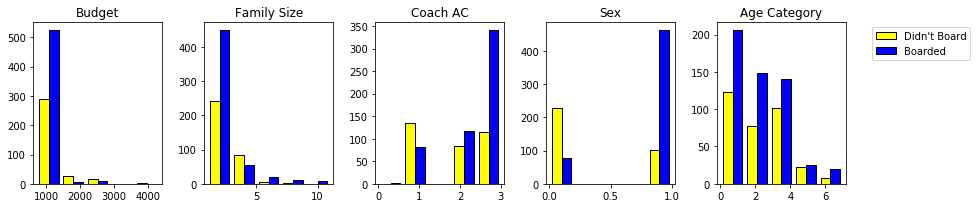

In [182]:
(X_train, y_train, X_val, y_val, X_test, y_test) = prepareRailwayData();
fig=plt.figure(figsize=(12, 3))
columns = X_train.shape[1]
rows = 1

featureMap = ['Budget', 'Family Size', 'Coach AC', 'Sex', 'Age Category']

#colors = ['violet', 'red', 'blue', 'green', 'indigo', 'yellow', 'orange', 'black', 'purple', 'maroon']
colors = ['yellow', 'blue']

for i in range(1, columns*rows +1):
    X_i = [X_train[np.where(y_train==c)][:,i-1] for c in np.unique(y_train)]
    ax = fig.add_subplot(rows, columns, i)
    ax.hist(X_i, color = colors, edgecolor = 'black', bins = 5, histtype = 'bar')
    ax.set_title(featureMap[i-1]) 
    
fig.tight_layout()

plt.legend(["Didn't Board", "Boarded"], bbox_to_anchor=(2, 1))
plt.show()

#Female = 1, Male = 0
#


### First Comments
- Priors of Boarding are much stronger than not boarding (logical): Trivial classifier won't suck
- Sex is a very useful discriminant: Men likely to board, women likely to not. Should test using this feature alone somehow.
- First AC bookings might be the business trips and subject to change of plans. Hence, not boarding is a thing.
- Large families definitely board, while middle size families are subject to change of plans
- Budget seems like a useless factor

In [219]:
(X_train, y_train, X_val, y_val, X_test, y_test) = prepareRailwayData(0);

y_pred = np.ones(y_test.shape)
acc = accuracy(y_pred, y_test)
print("Trivial Prediction: " + str(acc))





testX = np.array([X_test[:, 3]]).T
trainX = np.array([X_train[:, 3]]).T

#KNN estimation Only works for k larger than 100, because otherwise 
y_pred = naiveBayesClassifier(testX, trainX, y_train, kNearestNeighboursEstimation, lambda n: 200)
acc = accuracy(y_pred, y_test)
print("Only Sex Prediction [KNN Estimate]:" + str(acc))

y_pred = knnClassifier(testX, trainX, y_train, K = 50)
acc = accuracy(y_pred, y_test)
print("Only Sex Prediction [KNN Classifier]:" + str(acc))

y_pred = KMeansClassifier(testX, trainX, y_train, K = 2)[0]
acc = accuracy(y_pred, y_test)
print("Only Sex Prediction [K-Means Classifier]:" + str(acc))





testX = np.array([X_test[:, 2]]).T
trainX = np.array([X_train[:, 2]]).T

y_pred = knnClassifier(testX, trainX, y_train, K = 50)
acc = accuracy(y_pred, y_test)
print("Only Coach Prediction [KNN Classifier]:" + str(acc))

y_pred = KMeansClassifier(testX, trainX, y_train, K = 10)[0]
acc = accuracy(y_pred, y_test)
print("Only Coach Prediction [K-Means Classifier]:" + str(acc))




Trivial Prediction: 0.5844748858447488
Only Sex Prediction [KNN Estimate]:0.726027397260274
Only Sex Prediction [KNN Classifier]:0.726027397260274
Only Sex Prediction [K-Means Classifier]:0.726027397260274
Only Coach Prediction [KNN Classifier]:0.6529680365296804
Only Coach Prediction [K-Means Classifier]:0.5844748858447488


/Users/eshan/IIT Delhi/ELL409 - Machine Learning/ELL409/Assigment_1/classifiers.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  return predY
/Users/eshan/IIT Delhi/ELL409 - Machine Learning/ELL409/Assigment_1/classifiers.py:136: RuntimeWarning: Mean of empty slice.
  
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [222]:
(X_train, y_train, X_val, y_val, X_test, y_test) = prepareRailwayData(1);
y_pred = KMeansClassifier(X_test, X_train, y_train, K = 10)[0]
acc = accuracy(y_pred, y_test)
print("Only Coach Prediction [K-Means Classifier]:" + str(acc))




Only Coach Prediction [K-Means Classifier]:0.7579908675799086


In [179]:
X_train.shape

(873, 5)

In [65]:


(X_train, y_train, X_val, y_val, X_test, y_test) = prepareFMNISTData(0, 0.9);
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


n_samples = 200
print("n_samples = ", n_samples)
indices = random.sample(range(0, 10000), n_samples)
for K in [1, 3, 10, 30, 100, 300, 1000, 3000]:
    start = time.time()
    print("K: ", K)
    y_pred = bayesClassifier(X_val[indices], X_train, y_train, parzenWindowEstimation_gaussian, K) 
    #print(y_pred, y_test[indices])
    acc = accuracy(y_pred, y_val[indices])
    end = time.time()

    print("accuracy: ", acc)
    print("time taken: ", end-start)

    
#Accuracy peaks for K=30
K = 30
y_pred = bayesClassifier(X_test[indices], X_train, y_train, parzenWindowEstimation_gaussian, K) 
acc = accuracy(y_pred, y_test[indices])
print("K: ", K)
print("accuracy_test: ", acc)



PCA_Threshold = 0.9, P = 84
(48000, 84)
(12000, 84)
(10000, 84)
n_samples =  200
K:  1


KeyboardInterrupt: 

In [404]:
p

199

In [3]:
##MEDICAL DATA
(X_train, y_train, X_val, y_val, X_test, y_test) = prepareMedicalData()
print()
print("Train, Validation, Test")
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)





Train, Validation, Test
(2000, 3) (2000,)
(500, 3) (500,)
(500, 3) (500,)


In [4]:
#KNN
(X_train, y_train, X_val, y_val, X_test, y_test) = prepareMedicalData(0)
for K in [1, 3, 10, 30, 100, 300]:
    start = time.time()
    y_pred = knnClassifier(X_val, X_train, y_train, K, euclideanDistance )
    acc = accuracy(y_pred, y_val)
    end = time.time()
    print("K: ", K)
    print("accuracy_validation: ", acc)
    #print("time taken: ", end-start)

print("\n\n\n")
#Accuracy peaks for K=1
K = 1
y_pred = knnClassifier(X_test, X_train, y_train, K, euclideanDistance )
acc = accuracy(y_pred, y_test)
print("K: ", K)
print("accuracy_test: ", acc)



K:  1
accuracy_validation:  0.886
K:  3
accuracy_validation:  0.874
K:  10
accuracy_validation:  0.868
K:  30
accuracy_validation:  0.87
K:  100
accuracy_validation:  0.856
K:  300
accuracy_validation:  0.796




K:  1
accuracy_test:  0.88


In [2]:
#Normalized KNN
(X_train, y_train, X_val, y_val, X_test, y_test) = prepareMedicalData(1)
for K in [1, 3, 10, 30, 100, 300]:
    start = time.time()
    y_pred = knnClassifier(X_val, X_train, y_train, K, euclideanDistance )
    acc = accuracy(y_pred, y_val)
    end = time.time()
    print("K: ", K)
    print("accuracy_validation: ", acc)
    #print("time taken: ", end-start)

print("\n\n\n")
#Accuracy peaks for K=1
K = 1
y_pred = knnClassifier(X_test, X_train, y_train, K, euclideanDistance )
acc = accuracy(y_pred, y_test)
print("K: ", K)
print("accuracy_test: ", acc)




K:  1
accuracy_validation:  0.882
K:  3
accuracy_validation:  0.87
K:  10
accuracy_validation:  0.87
K:  30
accuracy_validation:  0.874
K:  100
accuracy_validation:  0.858
K:  300
accuracy_validation:  0.802




K:  1
accuracy_test:  0.878


In [6]:
#ParzenWindow  Bayes
(X_train, y_train, X_val, y_val, X_test, y_test) = prepareMedicalData(1)
for H in [np.sqrt, np.abs, np.log, lambda n: n/2]:
    start = time.time()
    y_pred = bayesClassifier(X_val, X_train, y_train, kNearestNeighboursEstimation, H)
    
    acc = accuracy(y_pred, y_val)
    end = time.time()
    print("H: ", H)
    print("accuracy_validation: ", acc)
    print("time taken: ", end-start)

print("\n\n\n")
#Accuracy peaks for H = 0.1
H = np.log
y_pred = bayesClassifier(X_test, X_train, y_train, kNearestNeighboursEstimation, H)
acc = accuracy(y_pred, y_test)
print("H: ", H)
print("accuracy_test: ", acc)



H:  <ufunc 'sqrt'>
accuracy_validation:  0.85
time taken:  0.09196090698242188
H:  <ufunc 'absolute'>
accuracy_validation:  0.526
time taken:  0.07190608978271484
H:  <ufunc 'log'>
accuracy_validation:  0.876
time taken:  0.08338785171508789
H:  <function <lambda> at 0x10b0ca730>
accuracy_validation:  0.73
time taken:  0.09158515930175781




H:  <ufunc 'log'>
accuracy_test:  0.86


H:  0.001
accuracy_validation:  0.368
time taken:  0.10532307624816895
H:  0.003
accuracy_validation:  0.664
time taken:  0.11775469779968262
H:  0.01
accuracy_validation:  0.874
time taken:  0.13130497932434082
H:  0.03
accuracy_validation:  0.884
time taken:  0.10846519470214844
H:  0.1
accuracy_validation:  0.89
time taken:  0.16126799583435059
H:  0.3
accuracy_validation:  0.882
time taken:  0.12857317924499512
H:  1
accuracy_validation:  0.796
time taken:  0.11747503280639648
H:  3
accuracy_validation:  0.716
time taken:  0.13397002220153809
H:  10
accuracy_validation:  0.322
time taken:  0.11418485641479492
H:  30
accuracy_validation:  0.322
time taken:  0.13682007789611816
H:  100
accuracy_validation:  0.322
time taken:  0.1607828140258789
H:  300
accuracy_validation:  0.322
time taken:  0.13089632987976074




H:  0.1
accuracy_test:  0.882


In [7]:



(X_train, y_train, X_val, y_val, X_test, y_test) = prepareRailwayData()
#print(railwayData.head())
#print()
#print("GROUPED Mean")
#print(railwayData[['boarded', 'budget', 'preferredClass', 'memberCount', 'sex', 'age']].groupby('sex').mean())
#print()
print("Train, Validation, Test")
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)



Train, Validation, Test
(873, 5) (873,)
(218, 5) (218,)
(219, 5) (219,)


In [8]:

#Unnormalized KNN with Euclidean Distance
(X_train, y_train, X_val, y_val, X_test, y_test) = prepareRailwayData(scale = 0)
for K in [1, 3, 10, 30, 100, 300]:
    start = time.time()
    y_pred = knnClassifier(X_val, X_train, y_train, K, euclideanDistance )
    acc = accuracy(y_pred, y_val)
    end = time.time()
    print("K: ", K)
    print("accuracy_validation: ", acc)
    #print("time taken: ", end-start)

print("\n\n\n")
#Accuracy peaks for K=3
K = 3
y_pred = knnClassifier(X_test, X_train, y_train, K, euclideanDistance )
acc = accuracy(y_pred, y_test)
print("K: ", K)
print("accuracy_test: ", acc)



K:  1
accuracy_validation:  0.7155963302752294
K:  3
accuracy_validation:  0.7844036697247706
K:  10
accuracy_validation:  0.7477064220183486
K:  30
accuracy_validation:  0.7385321100917431
K:  100
accuracy_validation:  0.6788990825688074
K:  300
accuracy_validation:  0.6972477064220184




K:  3
accuracy_test:  0.6940639269406392


In [3]:
# Normalized KNN with Euclidean Distance
(X_train, y_train, X_val, y_val, X_test, y_test) = prepareRailwayData(scale = 1)
for K in [1, 3, 10, 30, 100, 300]:
    start = time.time()
    y_pred = knnClassifier(X_val, X_train, y_train, K, euclideanDistance )
    acc = accuracy(y_pred, y_val)
    end = time.time()
    print("K: ", K)
    print("accuracy_validation: ", acc)
    #print("time taken: ", end-start)

print("\n\n\n")
#Accuracy peaks for K=30
K = 30
y_pred = knnClassifier(X_test, X_train, y_train, K, euclideanDistance)
acc = accuracy(y_pred, y_test)
print("K: ", K)
print("accuracy_test: ", acc)





K:  1
accuracy_validation:  0.7155963302752294
K:  3
accuracy_validation:  0.7889908256880734
K:  10
accuracy_validation:  0.7889908256880734
K:  30
accuracy_validation:  0.7935779816513762
K:  100
accuracy_validation:  0.7752293577981652
K:  300
accuracy_validation:  0.8027522935779816




K:  30
accuracy_test:  0.7488584474885844


In [167]:
(X_train, y_train, X_val, y_val, X_test, y_test) = prepareFMNISTData(0)

In [171]:
[Z, p, X, U, W] = PCA(X_train)

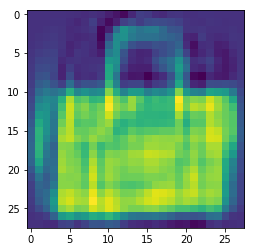

In [176]:
#plt.imshow(X_train[0].reshape(28,28))
plt.imshow(X[0].reshape(28,28))

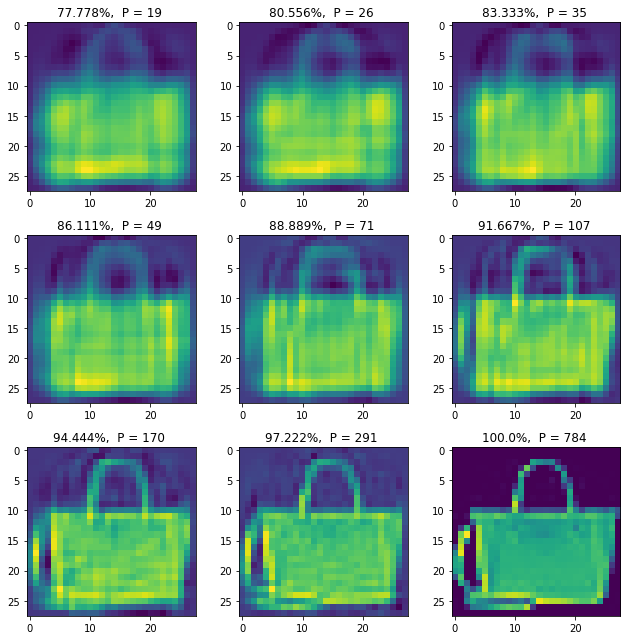

In [220]:
fig=plt.figure(figsize=(9, 9))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    threshold = 0.75 + i/(columns*rows*4)
    [Z, p, X, U, W] = PCA(X_train, threshold)
    img = X[0].reshape(28, 28)
    ax = fig.add_subplot(rows, columns, i)
    ax.imshow(img)
    ax.set_title(str(round(threshold*100,3))+ '%, '+ ' P = ' + str(p)+ ' ') 

fig.tight_layout()
plt.show()



In [217]:
str(round(5.5345345345,2))

'5.53'

In [1]:
(X_train, y_train, X_val, y_val, X_test, y_test) = prepareMedicalData(1,0,0)
start = time.time()
y_pred = KMeansClassifier(X_test, X_train, y_train, 20, euclideanDistance )
acc = accuracy(y_pred, y_test)
end = time.time()
print("time: ", end-start)
print("accuracy_validation: ", acc)

NameError: name 'prepareMedicalData' is not defined

# To Do: GMM Estimator
    Input: Training Data, Test Data, Estimation
    HyperParameter = K>=1: No. of Mixtures
    Predict: Ai, Ui, Si for i = [1, 2 ... K]

    WHAT IS A GOOD K?: Hard to measure directly. Check different K values on cross-validation set
    - Expect K to be similar to that of ideal choice for K-means clustering. 
    - GMM is quite similar to to the Parzen-window estimate where the larger K in PWE (due to number of training points) will make up for the provision of different Variances and Mixture Sizes in GMM. 
    
    Use Estimation for Bayes Classifier.
    
    

In [85]:
def gaussianMixtureModelEstimation(testX, trainX, K=1, distanceMetric = euclideanDistance, it=5):
    #Alpha(S) is a scalar
    #Nu(S) is a vector
    #Sigma(S) is a scalar, SI gives covariance matrix
    
    #Wt(ij): Probability of i'th point being in j'th matrix
    #Wt: N*K, W: K*N
    #trainX: n*d

    [N,D] = trainX.shape
    W = np.random.rand(K, N)
    W = W/np.sum(W, axis = 0)     #Probabilities across columns add to one

    mu = np.random.rand(K,D)
    sigma = np.random.rand(K, 1)
    alpha = np.random.rand(K, 1)
    alpha = alpha / np.sum(alpha, 1)
    
    #E-Step
    #M-step
    print(N,D,K)
    print('W', W.shape)
    numiter = 0
    while numiter < it:
        mu = (np.dot(W, trainX).transpose()/np.sum(W, axis = 1)).transpose()
#     print('Mu', mu.shape)
        sigma = np.zeros([K, D])
        for idx in range(K):
            sigma[idx] = np.sum(np.dot(np.dot(W[idx], trainX-mu[idx]), (trainX-mu[idx]).transpose()), axis=0)/np.sum(W[idx])
        alpha = np.sum(W, axis = 0)/N
        print(sigma)
        for idx in range(K):
            W[idx] = alpha[idx] * scipy.stats.multivariate_normal.pdf(trainX, mu[idx], sigma[idx])
            W[idx] = W[idx]/np.sum(W[idx])
        
        numiter = numiter+1
                   
#     print('Sigma', sigma.shape)
#     sigma = np.array( [np.square(euclideanDistance(trainX, mean)) for mean in mu])
    
   
    
    
    
    
                   
(X_train, y_train, X_val, y_val, X_test, y_test) = prepareMedicalData(scale = 1) 
gaussianMixtureModelEstimation(X_test, X_train, 50, 5)   

2000 3 50
W (50, 2000)
[[ 1.32440919e-15  1.32440919e-15  1.32440919e-15]
 [-2.16450441e-15 -2.16450441e-15 -2.16450441e-15]
 [ 9.57747472e-16  9.57747472e-16  9.57747472e-16]
 [ 5.55318537e-16  5.55318537e-16  5.55318537e-16]
 [-1.08591429e-15 -1.08591429e-15 -1.08591429e-15]
 [ 1.99636429e-16  1.99636429e-16  1.99636429e-16]
 [ 1.58944061e-16  1.58944061e-16  1.58944061e-16]
 [ 1.56272473e-15  1.56272473e-15  1.56272473e-15]
 [ 4.69033903e-16  4.69033903e-16  4.69033903e-16]
 [-9.75599074e-16 -9.75599074e-16 -9.75599074e-16]
 [-6.09924992e-16 -6.09924992e-16 -6.09924992e-16]
 [ 1.48179671e-16  1.48179671e-16  1.48179671e-16]
 [ 3.16064242e-16  3.16064242e-16  3.16064242e-16]
 [ 2.55592796e-16  2.55592796e-16  2.55592796e-16]
 [ 2.28991864e-15  2.28991864e-15  2.28991864e-15]
 [-5.55246577e-18 -5.55246577e-18 -5.55246577e-18]
 [ 9.62195203e-16  9.62195203e-16  9.62195203e-16]
 [ 3.44069574e-15  3.44069574e-15  3.44069574e-15]
 [ 1.25849660e-15  1.25849660e-15  1.25849660e-15]
 [-1.327

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


ValueError: the input matrix must be positive semidefinite

# KNN on Medical Dataset


In [85]:
distanceMetrics = [euclideanDistance, chebyschevDistance, manhattenDistance]
K_vals = [1,2,4,8,16, 32, 64, 128, 256]
params = {"Data": (0,-1,0), "Normalized": (1,-1,0), "PCA":(0,1,0), "90% PCA: p = 2": (0,0.9,0), "Whitening": (0,-1,1) }

log_cols = ["Data" ,"Distance Metric", "Validation_K", "Validation_Acc", "Test_Acc"]
log  = pd.DataFrame(columns=log_cols)
acc_dict = {}


for param in params:
    (x,y,z) = params[param]
    (X_train, y_train, X_val, y_val, X_test, y_test) = prepareMedicalData(x,y,z) 

    for dist in distanceMetrics:
        print(param + "    " + dist.__name__)
        maxAcc=0
        maxK=1
        for K in K_vals:
            
            name = dist.__name__ + " " + str(K)
            y_pred = knnClassifier(X_val, X_train, y_train, K, dist)
            acc = accuracy(y_pred, y_val)
            acc_dict[name] = acc
            if acc>maxAcc: 
                maxK = K
                maxAcc = acc
    
        y_pred = knnClassifier(X_test, X_train, y_train, maxK, dist)
        testAcc = accuracy(y_pred, y_test)
    
        classifier = [dist, maxK, maxAcc, testAcc]
        log_entry = pd.DataFrame([[param, dist.__name__, maxK, maxAcc, testAcc]], columns = log_cols)
        log = log.append(log_entry)

log.set_index('Data', inplace = True)

print('\n\n\n\n')
print(log)
print('\n\n\n\n')

     



Data    abc
Data    chebyschevDistance
Data    manhattenDistance
Normalized    abc
Normalized    chebyschevDistance
Normalized    manhattenDistance
PCA    abc
PCA    chebyschevDistance
PCA    manhattenDistance
90% PCA: p = 2    abc
90% PCA: p = 2    chebyschevDistance
90% PCA: p = 2    manhattenDistance
Whitening    abc
Whitening    chebyschevDistance
Whitening    manhattenDistance





                   Distance Metric Validation_K  Validation_Acc  Test_Acc
Data                                                                     
Data                           abc            1           0.886     0.880
Data            chebyschevDistance           16           0.882     0.864
Data             manhattenDistance            1           0.882     0.888
Normalized                     abc            1           0.882     0.878
Normalized      chebyschevDistance           16           0.884     0.868
Normalized       manhattenDistance            1           0.882     0.890
PCA               

'\nplt.xlabel(\'Accuracy\')\nplt.title(\'Classifier Accuracy\')\n\nsns.set_color_codes("muted")\nsns.barplot(x=\'Accuracy\', y=\'Classifier\', data=log, color="b")\n\nprint(log)\n'

# KNN on FMNIST Dataset

In [86]:
import seaborn as sns

distanceMetrics = [euclideanDistance, chebyschevDistance, manhattenDistance]
K_vals = [1,2,4,8,16, 32, 64, 128, 256, 512, 1024]
params ={"90% PCA": (0,0.9,0)}

log_cols = ["Data" ,"Distance Metric", "Validation_K", "Validation_Acc", "Test_Acc"]
log  = pd.DataFrame(columns=log_cols)
acc_dict = {}


for param in params:
    (x,y,z) = params[param]
    (X_train, y_train, X_val, y_val, X_test, y_test) = prepareFMNISTData(x,y,z) 

    for dist in distanceMetrics:
        print(param + "    " + dist.__name__)
        maxAcc=0
        maxK=1
        for K in K_vals:
            
            name = dist.__name__ + " " + str(K)
            y_pred = knnClassifier(X_val, X_train, y_train, K, dist)
            acc = accuracy(y_pred, y_val)
            acc_dict[name] = acc
            if acc>maxAcc: 
                maxK = K
                maxAcc = acc
    
        y_pred = knnClassifier(X_test, X_train, y_train, maxK, dist)
        testAcc = accuracy(y_pred, y_test)
    
        classifier = [dist, maxK, maxAcc, testAcc]
        log_entry = pd.DataFrame([[param, dist.__name__, maxK, maxAcc, testAcc]], columns = log_cols)
        log = log.append(log_entry)

log.set_index('Data', inplace = True)





PCA_Threshold = 0.9, P = 84
90% PCA    abc


KeyboardInterrupt: 

In [ ]:
euclideanDistance.__name__ = euclideanDistance

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


1
1.7390585774998577
1.7314275985720848


array([0.27566158, 0.14539401, 0.13583499, 0.23157008, 0.17288689,
       0.13692667, 0.18465583, 0.2593311 , 0.15157371, 0.112852  ,
       0.24376282, 0.03989132, 0.0852233 , 0.07383135, 0.19689855,
       0.28935204, 0.08731592, 0.3750283 , 0.09104794, 0.2488982 ,
       0.29721789, 0.1605503 , 0.26502337, 0.35492586, 0.22014878,
       0.29943297, 0.1861638 , 0.26757505, 0.24492069, 0.02394527,
       0.14682844, 0.07190557, 0.18798436, 0.22944668, 0.26826862,
       0.16304001, 0.21825885, 0.03635844, 0.24771874, 0.30801579,
       0.09710418, 0.17284295, 0.31165608, 0.32520941, 0.31221608,
       0.11461857, 0.18562218, 0.2072213 , 0.20353509, 0.36526896,
       0.0679655 , 0.19162171, 0.12690881, 0.15226875, 0.22206663,
       0.26269864, 0.33250663, 0.29582626, 0.36763885, 0.36672134,
       0.23021698, 0.11860091, 0.17955081, 0.3628174 , 0.1520939 ,
       0.24045343, 0.2707533 , 0.35623575, 0.23763785, 0.24071109,
       0.17340554, 0.23861007, 0.12829043, 0.27379567, 0.13207

In [30]:
print(X_val[np.where(y_val)==1])

[]


In [106]:
# Auto tuned Parzen Window with Euclidean Distance
(X_train, y_train, X_val, y_val, X_test, y_test) = prepareMedicalData(scale = 0)
y_pred = bayesClassifierAuto(X_test, X_train, y_train, X_val, y_val, parzenWindowEstimationAuto_gaussian, euclideanDistance )
acc = accuracy(y_pred, y_test)
print("accuracy_test: ", acc)



/Users/eshan/IIT Delhi/ELL409 - Machine Learning/ELL409/Assigment_1/classifiers.py:57: RuntimeWarning: divide by zero encountered in log
  logLikelyhood = np.sum(np.log(estimates), axis = 1)


accuracy_test:  0.796


In [107]:
#ParzenWindow Bayes
(X_train, y_train, X_val, y_val, X_test, y_test) = prepareMedicalData(scale = 0)

hMax = 0.001, 
accMax = 0
for H in [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300]:
    start = time.time()
    y_pred = bayesClassifier(X_val, X_train, y_train, parzenWindowEstimation_gaussian, H)
    acc = accuracy(y_pred, y_val)
    end = time.time()
    if acc>accMax: 
        hMax = H
        accMax = acc

    #print("H: ", H)
    #print("accuracy_validation: ", acc)
#    print("time taken: ", end-start)

print("\n\n\n")
#Accuracy peaks for H = 0.1
H = hMax
y_pred = bayesClassifier(X_test, X_train, y_train, parzenWindowEstimation_gaussian, H)
acc = accuracy(y_pred, y_test)
print("H: ", H)
print("accuracy_test: ", acc)








H:  0.3
accuracy_test:  0.87


In [120]:
# Auto tuned kNN with Euclidean Distance
(X_train, y_train, X_val, y_val, X_test, y_test) = prepareMedicalData(Whitening = 1)
y_pred = bayesClassifierAuto(X_test, X_train, y_train, X_val, y_val, kNearestNeighboursEstimationAuto, euclideanDistance )
acc = accuracy(y_pred, y_test)
print("accuracy_test: ", acc)




accuracy_test:  0.864


In [123]:
#ParzenWindow  Bayes
(X_train, y_train, X_val, y_val, X_test, y_test) = prepareMedicalData(Whitening = 1)
#for H in [np.sqrt, np.abs, np.log, lambda n: n/2]:
for H in [(lambda n: k) for k in [1,2,4,8,16,32,64,128,256,512]]: 
    start = time.time()
    y_pred = bayesClassifier(X_val, X_train, y_train, kNearestNeighboursEstimation, H)
    acc = accuracy(y_pred, y_val)
    end = time.time()
    print("H: ", H)
    print("accuracy_validation: ", acc)
    print("time taken: ", end-start)

print("\n\n\n")
#Accuracy peaks for H = 0.1
H = np.log
y_pred = bayesClassifier(X_test, X_train, y_train, kNearestNeighboursEstimation, H)
acc = accuracy(y_pred, y_test)
print("H: ", H)
print("accuracy_test: ", acc)



H:  <function <listcomp>.<lambda> at 0x10c66a7b8>
accuracy_validation:  0.718
time taken:  0.09042477607727051
H:  <function <listcomp>.<lambda> at 0x10c66abf8>
accuracy_validation:  0.718
time taken:  0.08697032928466797
H:  <function <listcomp>.<lambda> at 0x10c66a9d8>
accuracy_validation:  0.718
time taken:  0.08308291435241699
H:  <function <listcomp>.<lambda> at 0x10c66ad08>
accuracy_validation:  0.718
time taken:  0.08910679817199707
H:  <function <listcomp>.<lambda> at 0x10c66a268>
accuracy_validation:  0.718
time taken:  0.08362483978271484
H:  <function <listcomp>.<lambda> at 0x10c66a598>
accuracy_validation:  0.718
time taken:  0.08349990844726562
H:  <function <listcomp>.<lambda> at 0x10c66a0d0>
accuracy_validation:  0.718
time taken:  0.09331202507019043
H:  <function <listcomp>.<lambda> at 0x10c66a8c8>
accuracy_validation:  0.718
time taken:  0.08924484252929688
H:  <function <listcomp>.<lambda> at 0x10c66aae8>
accuracy_validation:  0.718
time taken:  0.08455514907836914
H

In [23]:
(X_train, y_train, X_val, y_val, X_test, y_test) = prepareMedicalData(scale = 1)
[y_pred,k, valAcc] = kMeansClassifierAuto(X_test, X_train, y_train, X_val, y_val, it = 1, distanceMetric = euclideanDistance)
print(k)
acc = accuracy(y_pred, y_test)
print(acc)
print(valAcc)


1 0 0.322
2 0 0.57
4 0 0.752
8 0 0.806
16 0 0.83
32 0 0.842
64 0 0.874
128 0 0.872
256 0 0.88
512 0 0.878
256
0.85
0.88


In [87]:
distanceMetrics = [euclideanDistance]
params = {"Data": (0,-1,0), "Normalized": (1,-1,0), "PCA":(0,1,0), "90% PCA: p = 2": (0,0.9,0), "Whitening": (0,-1,1), "Whitening + PCA": (0,1,1), "Normalized+PCA": (1,1,0) }
log_cols = ["Data" ,"Distance Metric", "Validation_K", "Validation_Acc", "Test_Acc"]
log  = pd.DataFrame(columns=log_cols)
acc_dict = {}


for param in params:
    (x,y,z) = params[param]
    (X_train, y_train, X_val, y_val, X_test, y_test) = prepareMedicalData(x,y,z) 

    for dist in distanceMetrics:
        print(param + "    " + dist.__name__)

        y_pred = bayesClassifierAuto(X_test, X_train, y_train, X_val, y_val, parzenWindowEstimationAuto_gaussian, distanceMetric = dist)
        
        testAcc = accuracy(y_pred, y_test)
    
        log_entry = pd.DataFrame([[param, dist.__name__, testAcc]], columns = log_cols)
        log = log.append(log_entry)

log.set_index('Data', inplace = True)

print('\n\n\n\n')
print(log)
print('\n\n\n\n')

     



Data    euclideanDistance


/home/sid/ELL409/Assigment_1/classifiers.py:65: RuntimeWarning: divide by zero encountered in log
  logLikelyhood = np.sum(np.log(estimates), axis = 1)


AssertionError: 5 columns passed, passed data had 3 columns

In [ ]:
# K Means medical
